# Import libraries

In [1]:
import numpy as np 
# import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxEDA
import datetime
from scipy import stats
from mpl_toolkits import mplot3d
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.stats import ks_2samp
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from sklearn.preprocessing import normalize
sns.set(color_codes = True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import data day 1

In [2]:
# Sampling frequency 4Hz ~= 0.25s
#6/27/2018
fl_eda_2 = pd.read_csv('../data/day_1/EDA.csv' , header= None)
fl_eda_2.columns  = ['eda']
fl_eda_freq_2 = fl_eda_2.iloc[1].values
print(len(fl_eda_2))
print('freq: ', fl_eda_freq_2)
fl_eda_2.head(10)

7640
freq:  [4.]


,eda
0,1.530146e+09
1,4.000000e+00
2,0.000000e+00
3,8.339960e-01
4,1.181441e+00
5,1.619646e+00
6,2.097595e+00
7,2.202845e+00
8,2.200282e+00
9,2.196439e+00


In [3]:
print(len(fl_eda_2))
fl_eda_2.head(5)

7640


,eda
0,1.530146e+09
1,4.000000e+00
2,0.000000e+00
3,8.339960e-01
4,1.181441e+00


## Convert time

In [4]:
fl_init_time_2 = datetime.datetime.fromtimestamp(fl_eda_2.iloc[0]).strftime('%Y-%m-%d %H:%M:%S')
fl_init_time_2

'2018-06-27 17:30:03'

In [5]:
fl_eda_2 = fl_eda_2.iloc[3:]

In [6]:
fl_time_eda_2 = pd.date_range(start=fl_init_time_2, periods=len(fl_eda_2), 
                              freq=str(1/int(fl_eda_freq_2))+'S')
fl_time_eda_2

DatetimeIndex([       '2018-06-27 17:30:03', '2018-06-27 17:30:03.250000',
               '2018-06-27 17:30:03.500000', '2018-06-27 17:30:03.750000',
                      '2018-06-27 17:30:04', '2018-06-27 17:30:04.250000',
               '2018-06-27 17:30:04.500000', '2018-06-27 17:30:04.750000',
                      '2018-06-27 17:30:05', '2018-06-27 17:30:05.250000',
               ...
               '2018-06-27 18:01:49.750000',        '2018-06-27 18:01:50',
               '2018-06-27 18:01:50.250000', '2018-06-27 18:01:50.500000',
               '2018-06-27 18:01:50.750000',        '2018-06-27 18:01:51',
               '2018-06-27 18:01:51.250000', '2018-06-27 18:01:51.500000',
               '2018-06-27 18:01:51.750000',        '2018-06-27 18:01:52'],
              dtype='datetime64[ns]', length=7637, freq='250L')

In [7]:
fl_eda_2 = fl_eda_2.set_index(fl_time_eda_2, drop =True)
fl_eda_2 = fl_eda_2[:]
fl_eda_2 = fl_eda_2.dropna()
print(len(fl_eda_2))
fl_eda_2.head()

7637


,eda
2018-06-27 17:30:03.000,0.833996
2018-06-27 17:30:03.250,1.181441
2018-06-27 17:30:03.500,1.619646
2018-06-27 17:30:03.750,2.097595
2018-06-27 17:30:04.000,2.202845


# Remove outliers

In [8]:
fl_exp2 = fl_eda_2.copy()#example dataset of normally distributed data. 


fl_exp2= fl_exp2[np.abs(fl_exp2.eda-fl_exp2.eda.mean())<=(3*fl_exp2.eda.std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
fl_exp2= fl_exp2[~(np.abs(fl_exp2.eda-fl_exp2.eda.mean())>(3*fl_exp2.eda.std()))] #or if you prefer the other way around
fl_exp2 = fl_exp2.dropna()
print(len(fl_exp2))
fl_exp2.head()

7637


,eda
2018-06-27 17:30:03.000,0.833996
2018-06-27 17:30:03.250,1.181441
2018-06-27 17:30:03.500,1.619646
2018-06-27 17:30:03.750,2.097595
2018-06-27 17:30:04.000,2.202845


## Time marks

In [9]:
tags_2 = pd.read_csv('../data/marks/6.27.csv' , header= None)
tags_2 = tags_2.drop(tags_2.columns[2],axis=1)
tags_2.columns  =  ['tagged_time','presence']
tags_2.head()

,tagged_time,presence
0,2018-06-27 18:00:24.518,1
1,2018-06-27 17:57:24.024,1
2,2018-06-27 17:55:35.289,1
3,2018-06-27 17:52:34.799,1
4,2018-06-27 17:41:07.577,1


In [10]:
tags_2.tagged_time[0]

'2018-06-27 18:00:24.518'

## Separate Data

In [23]:
cat_4 = fl_exp2.loc['2018-06-27 17:50:30.000':'2018-06-27 18:00:55.000']
cat_4.head()

,eda
2018-06-27 17:50:30.000,1.016347
2018-06-27 17:50:30.250,1.015066
2018-06-27 17:50:30.500,0.999693
2018-06-27 17:50:30.750,0.990725
2018-06-27 17:50:31.000,1.008660


# Visualization

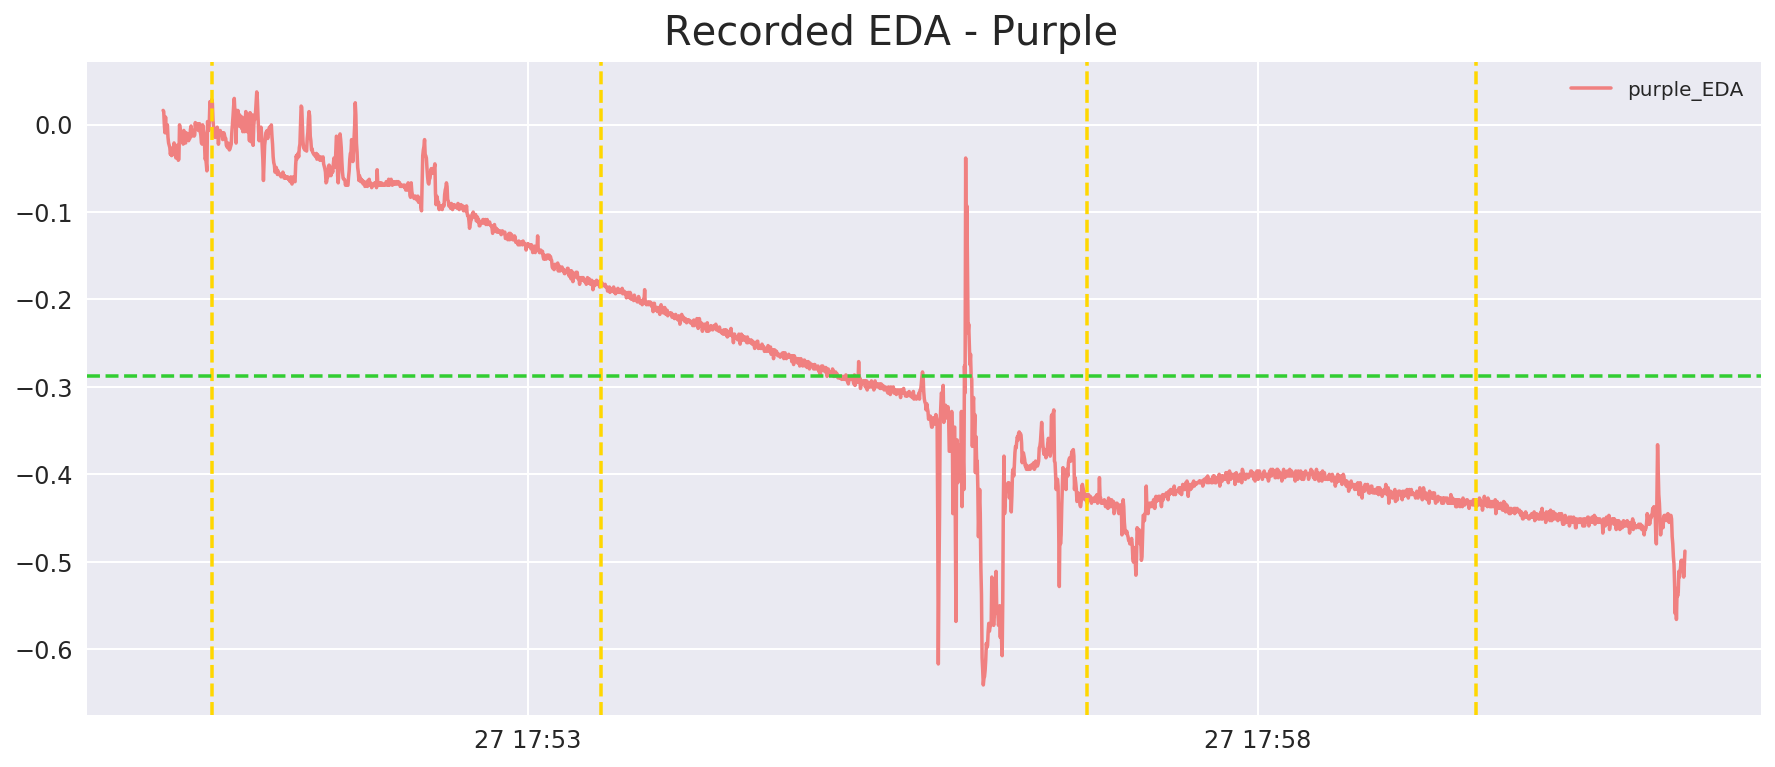

In [42]:
plt.figure(figsize=(15,6))
plt.plot(cat_4['eda'],color ='lightcoral')
plt.figtext(.5,.9,'Recorded EDA - Purple ', fontsize=20, ha='center')
plt.legend(['purple_EDA'],loc=1,fontsize='medium')
plt.axvline(x = '2018-06-27 17:50:50.000',color = 'gold',linestyle='--')
plt.axvline(x = '2018-06-27 17:53:30.000',color = 'gold',linestyle='--')
plt.axvline(x = '2018-06-27 17:56:50.000',color = 'gold',linestyle='--')
plt.axvline(x = '2018-06-27 17:59:30.000',color = 'gold',linestyle='--')
# # plt.axvline(x = tags_2.tagged_time[5],color = 'c',linestyle='--')

eda_mean = np.mean(cat_4.eda)
plt.axhline(y = eda_mean, color = 'limegreen', linestyle = '--')
plt.show()


# cvsEDA

In [37]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pl.rcParams.update(params)

In [38]:
y4 = np.asarray(cat_4.eda)
y4[:10]

array([1.016347, 1.015066, 0.999693, 0.990725, 1.00866 , 0.990725,
       0.990725, 0.999693, 0.985601, 0.979195])

In [39]:
yn4 = (y4 - y4.mean()) / y4.std()
Fs = 4.
[r4, p4, t4, l4, d4, e4, obj4] = cvxEDA.cvxEDA(yn4, 1./Fs)

# pl.rcParams['figure.figsize'] = (30,20)
tm4 = pl.arange(1., len(y4)+1.) / Fs


     pcost       dcost       gap    pres   dres
 0: -1.2404e+03 -1.2324e+03  5e+03  6e+01  4e-01
 1: -1.2410e+03 -1.9459e+03  9e+02  1e+01  7e-02
 2: -1.2437e+03 -1.4334e+03  2e+02  2e+00  1e-02
 3: -1.2446e+03 -1.3066e+03  6e+01  5e-01  3e-03
 4: -1.2449e+03 -1.2728e+03  3e+01  2e-01  1e-03
 5: -1.2458e+03 -1.2543e+03  8e+00  4e-02  3e-04
 6: -1.2477e+03 -1.2493e+03  2e+00  4e-04  3e-06
 7: -1.2483e+03 -1.2492e+03  9e-01  2e-04  1e-06
 8: -1.2488e+03 -1.2491e+03  3e-01  6e-05  3e-07
 9: -1.2490e+03 -1.2491e+03  1e-01  1e-05  6e-08
10: -1.2490e+03 -1.2491e+03  2e-02  2e-06  1e-08
11: -1.2490e+03 -1.2490e+03  6e-03  4e-07  2e-09
12: -1.2490e+03 -1.2490e+03  1e-03  6e-08  3e-10
13: -1.2490e+03 -1.2490e+03  3e-04  8e-09  5e-11
14: -1.2490e+03 -1.2490e+03  3e-05  4e-10  2e-12
15: -1.2490e+03 -1.2490e+03  2e-06  2e-11  1e-13
16: -1.2490e+03 -1.2490e+03  4e-08  4e-13  2e-14
Optimal solution found.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


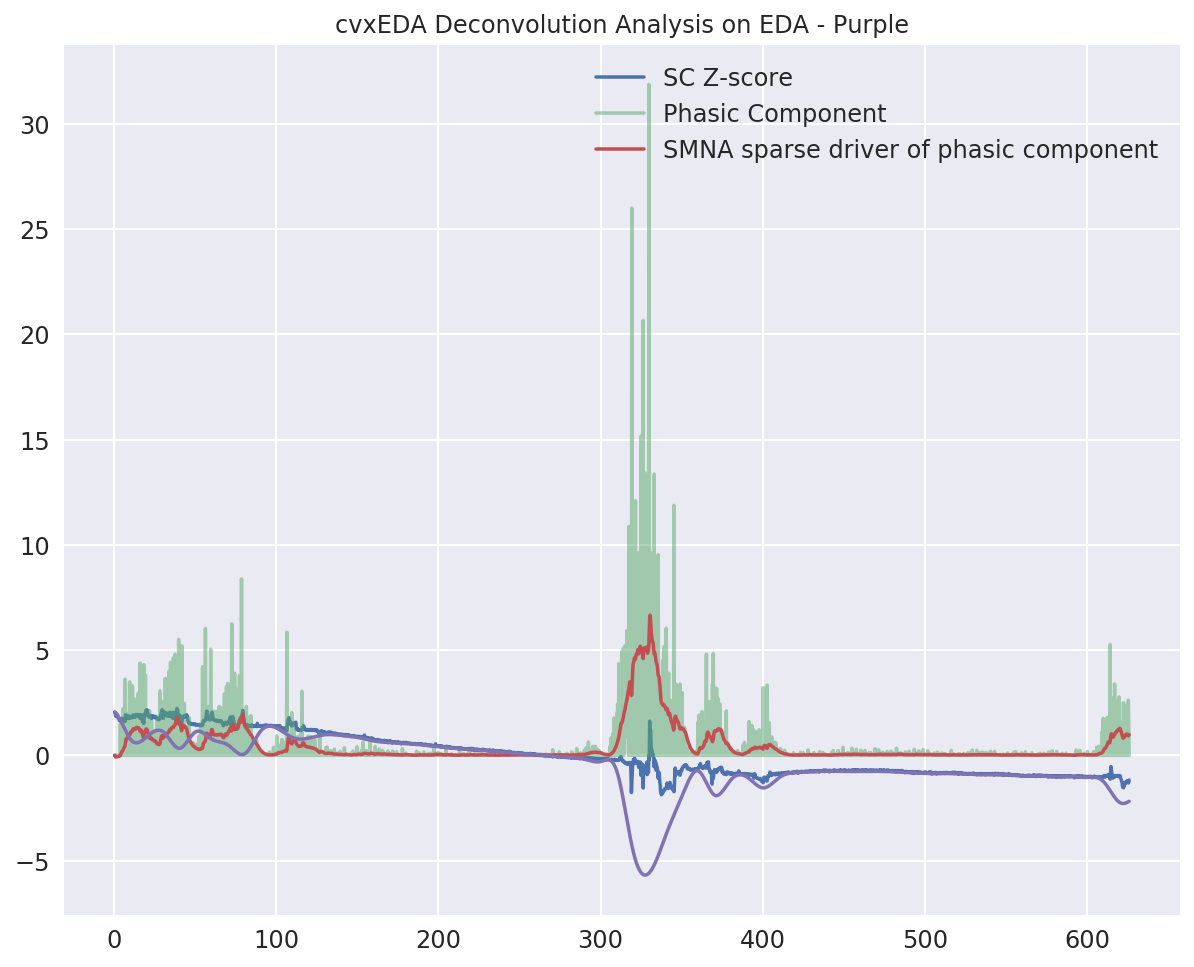

In [44]:
pl.hold(True)
pl.plot(tm4, yn4)
pl.plot(tm4, p4,alpha = 0.5)
pl.plot(tm4, r4)
pl.plot(tm4, t4)
# pl.plot(tm4, p4,alpha = 0.5)

pl.title('cvxEDA Deconvolution Analysis on EDA - Purple')
pl.legend(['SC Z-score','Phasic Component','SMNA sparse driver of phasic component',
           ])
plt.show()

## Logarithm 

In [41]:
fl_exp2['eda'] = np.log(fl_exp2['eda'])
fl_exp2.head(5)

,eda
2018-06-27 17:30:03.000,-0.181527
2018-06-27 17:30:03.250,0.166735
2018-06-27 17:30:03.500,0.482208
2018-06-27 17:30:03.750,0.740791
2018-06-27 17:30:04.000,0.789750


In [ ]:
log_eda_mean = np.mean(fl_exp2.eda)
print(log_eda_mean)
plt.figure(figsize=(15,6))
plt.plot(fl_exp2['eda'],color ='limegreen')
plt.figtext(.5,.9,'Stress response to cold showermodulated by social presence experiment- EDA ', fontsize=20, ha='center')
plt.legend(['EDA'],loc=1,fontsize='medium')
plt.axhline(y = log_eda_mean,color = 'salmon',linestyle='--')
plt.axvline(x = tags_2.tagged_time[0],color = 'hotpink',linestyle='--')
plt.axvline(x = tags_2.tagged_time[1],color = 'hotpink',linestyle='--')
plt.axvline(x = tags_2.tagged_time[3],color = 'c',linestyle='--')
plt.axvline(x = tags_2.tagged_time[4],color = 'c',linestyle='--')
plt.axvline(x = tags_2.tagged_time[5],color = 'c',linestyle='--')
plt.show()